# Basics

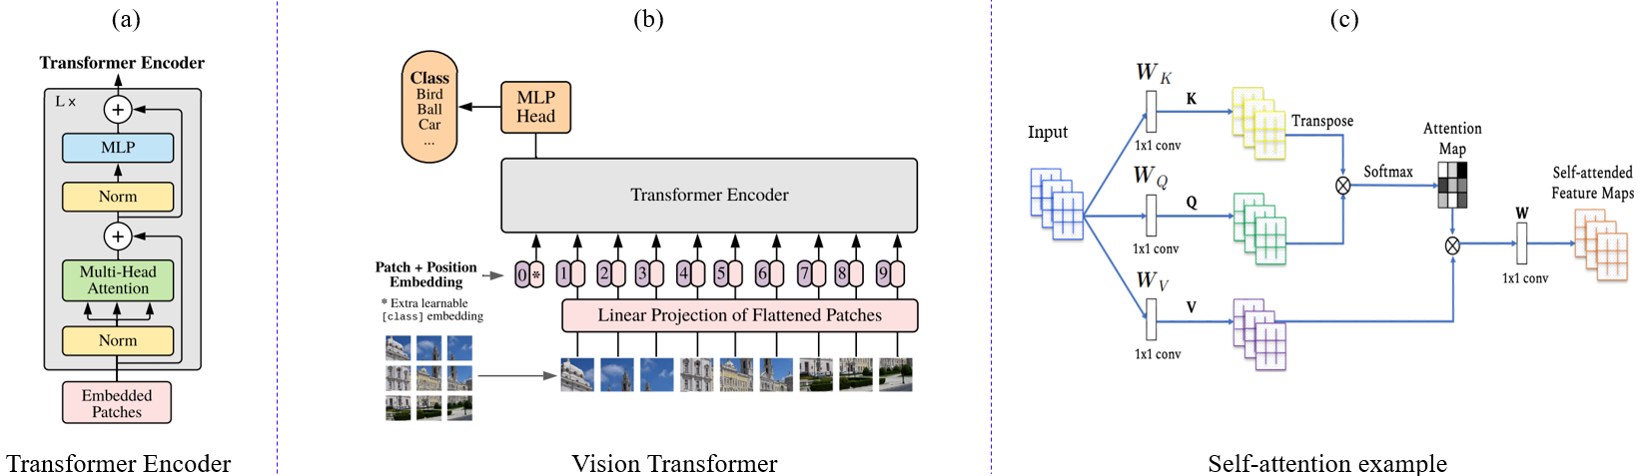

In [1]:
from IPython.display import Image

Image("https://ar5iv.labs.arxiv.org/html/2209.05700/assets/ViT.png")

## ViT

In [2]:
import torch
import torch.nn as nn

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_patches, dropout):
        super(PatchEmbedding, self).__init__()
        self. patcher = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2),
        )

        self.cls_token = nn.Parameter(torch.zeros(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embedding = nn.Parameter(torch.zeros(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = x + self.position_embedding
        x = self.dropout(x)
        return x

class ViT(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_patches, dropout,
                 num_heads, activation, num_encoders, num_classes):
        super(ViT, self).__init__()
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, embed_dim, num_patches, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout,
                                                   activation=activation, batch_first=True, norm_first=True)
        self.encoder_layers = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)
        self.MLP = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes),
        )

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder_layers(x)
        x = self.MLP(x[:, 0, :])
        return x

## Dataset

In [4]:
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

In [5]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTSubmissionDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "index": index}

## Load Data

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from dataset import MNISTSubmissionDataset, MNISTValDataset, MNISTTrainDataset

import numpy as np
from torch.utils.data import DataLoader, Dataset

In [7]:
def get_loaders(train_df_dir, test_df_dir, batch_size):
    train_df = pd.read_csv(train_df_dir)
    test_df = pd.read_csv(test_df_dir)

    train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

    train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values,
                                      train_df.index.values)
    val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values,
                                      val_df.index.values)
    test_dataset = MNISTSubmissionDataset(test_df.iloc[:, 1:].values.astype(np.uint8), test_df.index.values)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

## Train

In [8]:
import torch
import torch.nn as nn
from torch import optim
import timeit
from tqdm import tqdm
from utils import get_loaders
from model import ViT

DEVICE = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [9]:
# Hyper-Parameters

EPOCHS = 50

BATCH_SIZE = 16
TRAIN_DF_DIR = "./data/train.csv"
TEST_DF_DIR = "./data/test.csv"

# Model Parameters
IN_CHANNELS = 1
IMG_SIZE = 28
PATCH_SIZE = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
DROPOUT = 0.001

NUM_HEADS = 8
ACTIVATION = "gelu"
NUM_ENCODERS = 4
NUM_CLASSES = 10

LEARNING_RATE = 1e-4
ADAM_WEIGHT_DECAY = 0
ADAM_BEATS = (0.9, 0.999)

train_dataloader, val_dataloader, test_dataloader = get_loaders(TRAIN_DF_DIR, TEST_DF_DIR, batch_size=BATCH_SIZE)

model = ViT(IN_CHANNELS, PATCH_SIZE, EMBED_DIM, NUM_PATCHES, DROPOUT,
            NUM_HEADS, ACTIVATION, NUM_ENCODERS, NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas = ADAM_BEATS, lr = LEARNING_RATE, weight_decay = ADAM_WEIGHT_DECAY)

start = timeit.default_timer()

for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_loss = 0

    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(DEVICE)
        label = img_label["label"].type(torch.uint8).to(DEVICE)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim = 1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_loss = 0

    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(DEVICE)
            label = img_label["label"].type(torch.uint8).to(DEVICE)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim = 1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_loss += loss.item()

    val_loss = val_loss / (idx + 1)

    print("-" * 30)
    print(f"Train Loss Epoch {epoch+1} : {train_loss:.4f}")
    print(f"Val Loss Epoch {epoch+1} : {val_loss:.4f}")
    print(
        f"Train Acc Epoch {epoch+1} : {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(
        f"Val Acc Epoch {epoch+1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-" * 30)

stop = timeit.default_timer()
print(f"Training Time: {stop - start:.2f}s")

/proj/ciptmp/ir36ukaq/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  2%|▏         | 1/50 [00:18<14:59, 18.36s/it]

------------------------------
Train Loss Epoch 1 : 1.6145
Val Loss Epoch 1 : 1.1458
Train Acc Epoch 1 : 0.4300
Val Acc Epoch 1: 0.6208
------------------------------


  4%|▍         | 2/50 [00:36<14:44, 18.44s/it]

------------------------------
Train Loss Epoch 2 : 1.0233
Val Loss Epoch 2 : 0.7351
Train Acc Epoch 2 : 0.6497
Val Acc Epoch 2: 0.7585
------------------------------


  6%|▌         | 3/50 [00:55<14:27, 18.46s/it]

------------------------------
Train Loss Epoch 3 : 0.6768
Val Loss Epoch 3 : 0.4516
Train Acc Epoch 3 : 0.7769
Val Acc Epoch 3: 0.8600
------------------------------


  8%|▊         | 4/50 [01:14<14:13, 18.55s/it]

------------------------------
Train Loss Epoch 4 : 0.4883
Val Loss Epoch 4 : 0.3360
Train Acc Epoch 4 : 0.8454
Val Acc Epoch 4: 0.8972
------------------------------


 10%|█         | 5/50 [01:32<13:52, 18.50s/it]

------------------------------
Train Loss Epoch 5 : 0.3788
Val Loss Epoch 5 : 0.2431
Train Acc Epoch 5 : 0.8812
Val Acc Epoch 5: 0.9243
------------------------------


 12%|█▏        | 6/50 [01:50<13:32, 18.47s/it]

------------------------------
Train Loss Epoch 6 : 0.3156
Val Loss Epoch 6 : 0.2105
Train Acc Epoch 6 : 0.8999
Val Acc Epoch 6: 0.9358
------------------------------


 14%|█▍        | 7/50 [02:09<13:13, 18.44s/it]

------------------------------
Train Loss Epoch 7 : 0.2729
Val Loss Epoch 7 : 0.2113
Train Acc Epoch 7 : 0.9142
Val Acc Epoch 7: 0.9358
------------------------------


 16%|█▌        | 8/50 [02:27<12:54, 18.45s/it]

------------------------------
Train Loss Epoch 8 : 0.2453
Val Loss Epoch 8 : 0.1797
Train Acc Epoch 8 : 0.9223
Val Acc Epoch 8: 0.9453
------------------------------


 18%|█▊        | 9/50 [02:46<12:36, 18.45s/it]

------------------------------
Train Loss Epoch 9 : 0.2239
Val Loss Epoch 9 : 0.1392
Train Acc Epoch 9 : 0.9300
Val Acc Epoch 9: 0.9563
------------------------------


 20%|██        | 10/50 [03:04<12:17, 18.44s/it]

------------------------------
Train Loss Epoch 10 : 0.2042
Val Loss Epoch 10 : 0.1362
Train Acc Epoch 10 : 0.9362
Val Acc Epoch 10: 0.9603
------------------------------


 22%|██▏       | 11/50 [03:22<11:58, 18.43s/it]

------------------------------
Train Loss Epoch 11 : 0.1878
Val Loss Epoch 11 : 0.1311
Train Acc Epoch 11 : 0.9403
Val Acc Epoch 11: 0.9603
------------------------------


 24%|██▍       | 12/50 [03:41<11:40, 18.43s/it]

------------------------------
Train Loss Epoch 12 : 0.1774
Val Loss Epoch 12 : 0.1221
Train Acc Epoch 12 : 0.9445
Val Acc Epoch 12: 0.9642
------------------------------


 26%|██▌       | 13/50 [03:59<11:23, 18.46s/it]

------------------------------
Train Loss Epoch 13 : 0.1650
Val Loss Epoch 13 : 0.1092
Train Acc Epoch 13 : 0.9478
Val Acc Epoch 13: 0.9672
------------------------------


 28%|██▊       | 14/50 [04:18<11:04, 18.46s/it]

------------------------------
Train Loss Epoch 14 : 0.1581
Val Loss Epoch 14 : 0.1109
Train Acc Epoch 14 : 0.9504
Val Acc Epoch 14: 0.9657
------------------------------


 30%|███       | 15/50 [04:36<10:46, 18.46s/it]

------------------------------
Train Loss Epoch 15 : 0.1473
Val Loss Epoch 15 : 0.1305
Train Acc Epoch 15 : 0.9537
Val Acc Epoch 15: 0.9580
------------------------------


 32%|███▏      | 16/50 [04:55<10:27, 18.44s/it]

------------------------------
Train Loss Epoch 16 : 0.1415
Val Loss Epoch 16 : 0.0957
Train Acc Epoch 16 : 0.9556
Val Acc Epoch 16: 0.9688
------------------------------


 34%|███▍      | 17/50 [05:13<10:08, 18.45s/it]

------------------------------
Train Loss Epoch 17 : 0.1386
Val Loss Epoch 17 : 0.1059
Train Acc Epoch 17 : 0.9555
Val Acc Epoch 17: 0.9678
------------------------------


 36%|███▌      | 18/50 [05:32<09:50, 18.44s/it]

------------------------------
Train Loss Epoch 18 : 0.1319
Val Loss Epoch 18 : 0.1066
Train Acc Epoch 18 : 0.9586
Val Acc Epoch 18: 0.9657
------------------------------


 38%|███▊      | 19/50 [05:50<09:32, 18.45s/it]

------------------------------
Train Loss Epoch 19 : 0.1299
Val Loss Epoch 19 : 0.0870
Train Acc Epoch 19 : 0.9592
Val Acc Epoch 19: 0.9713
------------------------------


 40%|████      | 20/50 [06:09<09:15, 18.53s/it]

------------------------------
Train Loss Epoch 20 : 0.1247
Val Loss Epoch 20 : 0.0797
Train Acc Epoch 20 : 0.9604
Val Acc Epoch 20: 0.9757
------------------------------


 42%|████▏     | 21/50 [06:27<08:57, 18.52s/it]

------------------------------
Train Loss Epoch 21 : 0.1163
Val Loss Epoch 21 : 0.0836
Train Acc Epoch 21 : 0.9626
Val Acc Epoch 21: 0.9748
------------------------------


 44%|████▍     | 22/50 [06:46<08:38, 18.52s/it]

------------------------------
Train Loss Epoch 22 : 0.1142
Val Loss Epoch 22 : 0.0972
Train Acc Epoch 22 : 0.9623
Val Acc Epoch 22: 0.9683
------------------------------


 46%|████▌     | 23/50 [07:04<08:19, 18.50s/it]

------------------------------
Train Loss Epoch 23 : 0.1101
Val Loss Epoch 23 : 0.0830
Train Acc Epoch 23 : 0.9648
Val Acc Epoch 23: 0.9743
------------------------------


 48%|████▊     | 24/50 [07:23<08:00, 18.49s/it]

------------------------------
Train Loss Epoch 24 : 0.1084
Val Loss Epoch 24 : 0.0718
Train Acc Epoch 24 : 0.9650
Val Acc Epoch 24: 0.9793
------------------------------


 50%|█████     | 25/50 [07:41<07:42, 18.50s/it]

------------------------------
Train Loss Epoch 25 : 0.1048
Val Loss Epoch 25 : 0.0708
Train Acc Epoch 25 : 0.9661
Val Acc Epoch 25: 0.9777
------------------------------


 52%|█████▏    | 26/50 [08:00<07:23, 18.48s/it]

------------------------------
Train Loss Epoch 26 : 0.1016
Val Loss Epoch 26 : 0.0709
Train Acc Epoch 26 : 0.9683
Val Acc Epoch 26: 0.9795
------------------------------


 54%|█████▍    | 27/50 [08:18<07:04, 18.46s/it]

------------------------------
Train Loss Epoch 27 : 0.0997
Val Loss Epoch 27 : 0.0706
Train Acc Epoch 27 : 0.9686
Val Acc Epoch 27: 0.9793
------------------------------


 56%|█████▌    | 28/50 [08:37<06:46, 18.46s/it]

------------------------------
Train Loss Epoch 28 : 0.0979
Val Loss Epoch 28 : 0.0654
Train Acc Epoch 28 : 0.9685
Val Acc Epoch 28: 0.9782
------------------------------


 58%|█████▊    | 29/50 [08:55<06:27, 18.45s/it]

------------------------------
Train Loss Epoch 29 : 0.0957
Val Loss Epoch 29 : 0.0675
Train Acc Epoch 29 : 0.9699
Val Acc Epoch 29: 0.9785
------------------------------


 60%|██████    | 30/50 [09:13<06:09, 18.45s/it]

------------------------------
Train Loss Epoch 30 : 0.0955
Val Loss Epoch 30 : 0.0623
Train Acc Epoch 30 : 0.9699
Val Acc Epoch 30: 0.9800
------------------------------


 62%|██████▏   | 31/50 [09:32<05:50, 18.46s/it]

------------------------------
Train Loss Epoch 31 : 0.0938
Val Loss Epoch 31 : 0.0669
Train Acc Epoch 31 : 0.9698
Val Acc Epoch 31: 0.9780
------------------------------


 64%|██████▍   | 32/50 [09:50<05:32, 18.47s/it]

------------------------------
Train Loss Epoch 32 : 0.0927
Val Loss Epoch 32 : 0.0679
Train Acc Epoch 32 : 0.9705
Val Acc Epoch 32: 0.9782
------------------------------


 66%|██████▌   | 33/50 [10:09<05:13, 18.46s/it]

------------------------------
Train Loss Epoch 33 : 0.0870
Val Loss Epoch 33 : 0.0632
Train Acc Epoch 33 : 0.9719
Val Acc Epoch 33: 0.9810
------------------------------


 68%|██████▊   | 34/50 [10:27<04:55, 18.45s/it]

------------------------------
Train Loss Epoch 34 : 0.0874
Val Loss Epoch 34 : 0.0624
Train Acc Epoch 34 : 0.9719
Val Acc Epoch 34: 0.9790
------------------------------


 70%|███████   | 35/50 [10:46<04:36, 18.45s/it]

------------------------------
Train Loss Epoch 35 : 0.0849
Val Loss Epoch 35 : 0.0653
Train Acc Epoch 35 : 0.9725
Val Acc Epoch 35: 0.9787
------------------------------


 72%|███████▏  | 36/50 [11:05<04:19, 18.54s/it]

------------------------------
Train Loss Epoch 36 : 0.0826
Val Loss Epoch 36 : 0.0630
Train Acc Epoch 36 : 0.9736
Val Acc Epoch 36: 0.9802
------------------------------


 74%|███████▍  | 37/50 [11:23<04:00, 18.53s/it]

------------------------------
Train Loss Epoch 37 : 0.0787
Val Loss Epoch 37 : 0.0655
Train Acc Epoch 37 : 0.9745
Val Acc Epoch 37: 0.9797
------------------------------


 76%|███████▌  | 38/50 [11:42<03:42, 18.53s/it]

------------------------------
Train Loss Epoch 38 : 0.0812
Val Loss Epoch 38 : 0.0588
Train Acc Epoch 38 : 0.9739
Val Acc Epoch 38: 0.9803
------------------------------


 78%|███████▊  | 39/50 [12:00<03:23, 18.52s/it]

------------------------------
Train Loss Epoch 39 : 0.0804
Val Loss Epoch 39 : 0.0629
Train Acc Epoch 39 : 0.9736
Val Acc Epoch 39: 0.9795
------------------------------


 80%|████████  | 40/50 [12:19<03:04, 18.50s/it]

------------------------------
Train Loss Epoch 40 : 0.0773
Val Loss Epoch 40 : 0.0620
Train Acc Epoch 40 : 0.9752
Val Acc Epoch 40: 0.9817
------------------------------


 82%|████████▏ | 41/50 [12:37<02:46, 18.50s/it]

------------------------------
Train Loss Epoch 41 : 0.0759
Val Loss Epoch 41 : 0.0590
Train Acc Epoch 41 : 0.9752
Val Acc Epoch 41: 0.9823
------------------------------


 84%|████████▍ | 42/50 [12:56<02:28, 18.52s/it]

------------------------------
Train Loss Epoch 42 : 0.0729
Val Loss Epoch 42 : 0.0629
Train Acc Epoch 42 : 0.9763
Val Acc Epoch 42: 0.9798
------------------------------


 86%|████████▌ | 43/50 [13:14<02:09, 18.49s/it]

------------------------------
Train Loss Epoch 43 : 0.0742
Val Loss Epoch 43 : 0.0567
Train Acc Epoch 43 : 0.9761
Val Acc Epoch 43: 0.9827
------------------------------


 88%|████████▊ | 44/50 [13:32<01:50, 18.47s/it]

------------------------------
Train Loss Epoch 44 : 0.0714
Val Loss Epoch 44 : 0.0551
Train Acc Epoch 44 : 0.9770
Val Acc Epoch 44: 0.9818
------------------------------


 90%|█████████ | 45/50 [13:51<01:32, 18.47s/it]

------------------------------
Train Loss Epoch 45 : 0.0710
Val Loss Epoch 45 : 0.0571
Train Acc Epoch 45 : 0.9770
Val Acc Epoch 45: 0.9827
------------------------------


 92%|█████████▏| 46/50 [14:09<01:13, 18.48s/it]

------------------------------
Train Loss Epoch 46 : 0.0710
Val Loss Epoch 46 : 0.0550
Train Acc Epoch 46 : 0.9763
Val Acc Epoch 46: 0.9822
------------------------------


 94%|█████████▍| 47/50 [14:28<00:55, 18.48s/it]

------------------------------
Train Loss Epoch 47 : 0.0713
Val Loss Epoch 47 : 0.0540
Train Acc Epoch 47 : 0.9772
Val Acc Epoch 47: 0.9833
------------------------------


 96%|█████████▌| 48/50 [14:46<00:36, 18.47s/it]

------------------------------
Train Loss Epoch 48 : 0.0710
Val Loss Epoch 48 : 0.0557
Train Acc Epoch 48 : 0.9778
Val Acc Epoch 48: 0.9825
------------------------------


 98%|█████████▊| 49/50 [15:05<00:18, 18.47s/it]

------------------------------
Train Loss Epoch 49 : 0.0683
Val Loss Epoch 49 : 0.0585
Train Acc Epoch 49 : 0.9773
Val Acc Epoch 49: 0.9817
------------------------------


100%|██████████| 50/50 [15:23<00:00, 18.48s/it]

------------------------------
Train Loss Epoch 50 : 0.0671
Val Loss Epoch 50 : 0.0555
Train Acc Epoch 50 : 0.9781
Val Acc Epoch 50: 0.9832
------------------------------
Training Time: 923.80s
